In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context("talk")
sns.set_style("whitegrid")

In [ ]:
# Load the saved model and scalers
model_dir = '/path/to/models'  # Update with the actual path
# Load the model with the specified custom objects if needed
model = tf.keras.models.load_model(
    os.path.join(model_dir, 'sliding_window_multi_output_model.keras'),
    custom_objects={
        'MeanSquaredError': tf.keras.losses.MeanSquaredError
    }
)

In [4]:
X_scaler = joblib.load(os.path.join(model_dir, 'X_scaler.joblib'))
y_T_scaler = joblib.load(os.path.join(model_dir, 'y_T_scaler.joblib'))
y_q_scaler = joblib.load(os.path.join(model_dir, 'y_q_scaler.joblib'))
y_dq_scaler = joblib.load(os.path.join(model_dir, 'y_dq_scaler.joblib'))

In [5]:
# Load and preprocess the new signature data
new_signature_filepath = '/path/to/new_signature.csv'  # Update with the actual path
new_signature_df = pd.read_csv(new_signature_filepath)

In [13]:
# Number of preceding and succeeding points to include
n_points = 5

# Initialize a list to store the combined data for each row
all_combined_data = []

# Iterate through the rows of the new signature dataframe
for i in range(len(new_signature_df)):
    row = new_signature_df.iloc[i]

    # Extract the features of the current point (assuming features are in columns 1 and 2)
    current_features = row[1:3]

    # Initialize lists for preceding and succeeding features
    preceding_features = []
    succeeding_features = []

    # Preceding points
    for j in range(i - n_points, i):
        if j >= 0:
            preceding_features.extend(new_signature_df.iloc[j][1:3])
        else:
            preceding_features.extend([0, 0])

    # Succeeding points
    for j in range(i + 1, i + n_points + 1):
        if j < len(new_signature_df):
            succeeding_features.extend(new_signature_df.iloc[j][1:3])
        else:
            succeeding_features.extend([0, 0])

    # Combine all features
    combined_data = current_features.tolist() + preceding_features + succeeding_features

    # Add the combined data to the list
    all_combined_data.append(combined_data)

# Convert the combined data into a numpy array
X_new_prepared = np.array(all_combined_data)

In [18]:
# Normalize the new data using the pre-fitted scaler
X_new_normalized = X_scaler.transform(X_new_prepared)

In [19]:
# Predict using the model
predictions = model.predict(X_new_normalized)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [20]:
# Inverse transform the predictions to get them back to the original scale
y_T_pred = y_T_scaler.inverse_transform(predictions[0])     # Force torques
y_q_pred = y_q_scaler.inverse_transform(predictions[1])     # Angular positions
y_dq_pred = y_dq_scaler.inverse_transform(predictions[2])   # Angular velocities

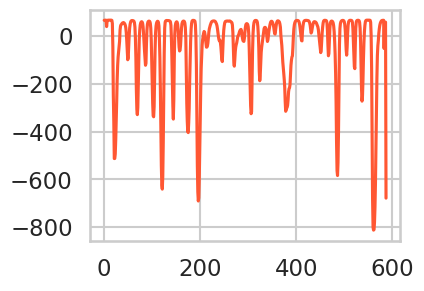

In [26]:
# Plotting the first component of the force torque predictions
plt.figure(figsize=(4, 3))
plt.plot(y_T_pred[:,0], color='#FF5733')
plt.show()